In [6]:
!git clone https://github.com/adrienloizeau/car_dectector.git 

fatal: destination path '.' already exists and is not an empty directory.


In [2]:
#! zsh 
# Install Kaggle
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!# Downloading datasets
!kaggle competitions download -c vic-kaggle-challenge-2023

!# Unzipping datasets
!pip install unzip
!unzip vic-kaggle-challenge-2023
!rm -rf vic-kaggle-challenge-2023

100% 315M/315M [00:02<00:00, 131MB/s]
100% 315M/315M [00:02<00:00, 137MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1311 sha256=188432a636e81fb011f62bcd4fa2b020f255173da848c47cbfebb9f072639305
  Stored in directory: /root/.cache/pip/wheels/88/2c/2b/d12ab5bb9f34eba42f98231b969311f33d7dc1a2f484b902d1
Successfully built unzip
Archive:  vic-kaggle-challenge-2023.zip
  inflating: Assignment2/Assignment2.ipynb  
  inflating: Assignment2/sample_submission.csv  
  inflating: Assignment2/test/test/001.jpg  
  inflating: Assignment2/test/test/002.jpg  
  inflating: Assignment2/test/test/003.jpg  
  inflating: Assignment2/test/test/004.jpg  
  inflating: Assignment2/test/test/005.jpg  
  inflating: Assignment2/test/test/006.jpg  
  inflating: Assignment2/test/test/007.jpg  
  inflating: Assignment2/test/test/008.jpg  
  inflating

Now that we have a dataset, some models and a sliding window, let's found the cars

In [1]:
import cv2
import numpy as np
from itertools import zip_longest

# Load image and boxes
image = cv2.imread("test/001.jpg")

def grouper(n, iterable, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

def overlap(box1, box2, threshold=0.5):
    """
    Determine if two boxes overlap based on their intersection over union (IoU).
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x1 >= x2 or y1 >= y2:
        return False
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = intersection / float(area1 + area2 - intersection)
    return iou >= threshold

# Create heatmap
def create_map(boxes, img):
    heatmap = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)

    for x,y,w, h in grouper(4, boxes):
        heatmap[y:y+h,x:x+w] += 1.0

    # Threshold heatmap
    threshold = 1
    heatmap[heatmap < threshold] = 0.0
    heatmap[heatmap >= threshold] = 1.0
    return heatmap

def connect_components(heatmap):
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(heatmap.astype(np.uint8))

    # Compute bounding boxes
    bboxes = []
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        bboxes.append([x, y, width, height])

    # Merge overlapping bounding boxes
    merged_bboxes = []
    while len(bboxes) > 0:
        bbox = bboxes.pop(0)
        merged_bbox = bbox
        i = 0
        while i < len(bboxes):
            if overlap(merged_bbox, bboxes[i]):
                merged_bbox = merge(merged_bbox, bboxes[i])
                bboxes.pop(i)
            else:
                i += 1
        merged_bboxes.append(merged_bbox)
    return merged_bboxes

def create_submission_file(boxes_list, files_names):
    rows = []
    for i, file_name in enumerate(files_names):
        rle = run_length_encoding(bounding_boxes_to_mask(boxes_list[i], H, W))
        rows.append(['test/' + file_name, rle])

    df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
    df_prediction.to_csv('sample_submission2.csv')
    print("file created")

def read_img(path: str):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread


H, W = 720, 1280

def read_frame(df_annotation, frame):
    """Read frames and create integer frame_id-s"""
    file_path = df_annotation[df_annotation.index == frame]['frame_id'].values[0]
    return imread(file_path)

def annotations_for_frame(df_annotation, frame):
    assert frame in df_annotation.index
    bbs = df_annotation[df_annotation.index == frame].bounding_boxes.values[0]

    if pd.isna(bbs): # some frames contain no vehicles
        return []

    bbs = list(map(lambda x : int(x), bbs.split(' ')))
    return np.array_split(bbs, len(bbs) / 4)

def show_annotation(df_annotation, frame):
    img = read_frame(df_annotation, frame)
    bbs = annotations_for_frame(df_annotation, frame)

    fig, ax = plt.subplots(figsize=(10, 8))

    for x, y, dx, dy in bbs:

        rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(img)
    ax.set_title('Annotations for frame {}.'.format(frame))

def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """

    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]

    if len(non_zeros) == 0:
        return ''
    
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

### For one image

/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


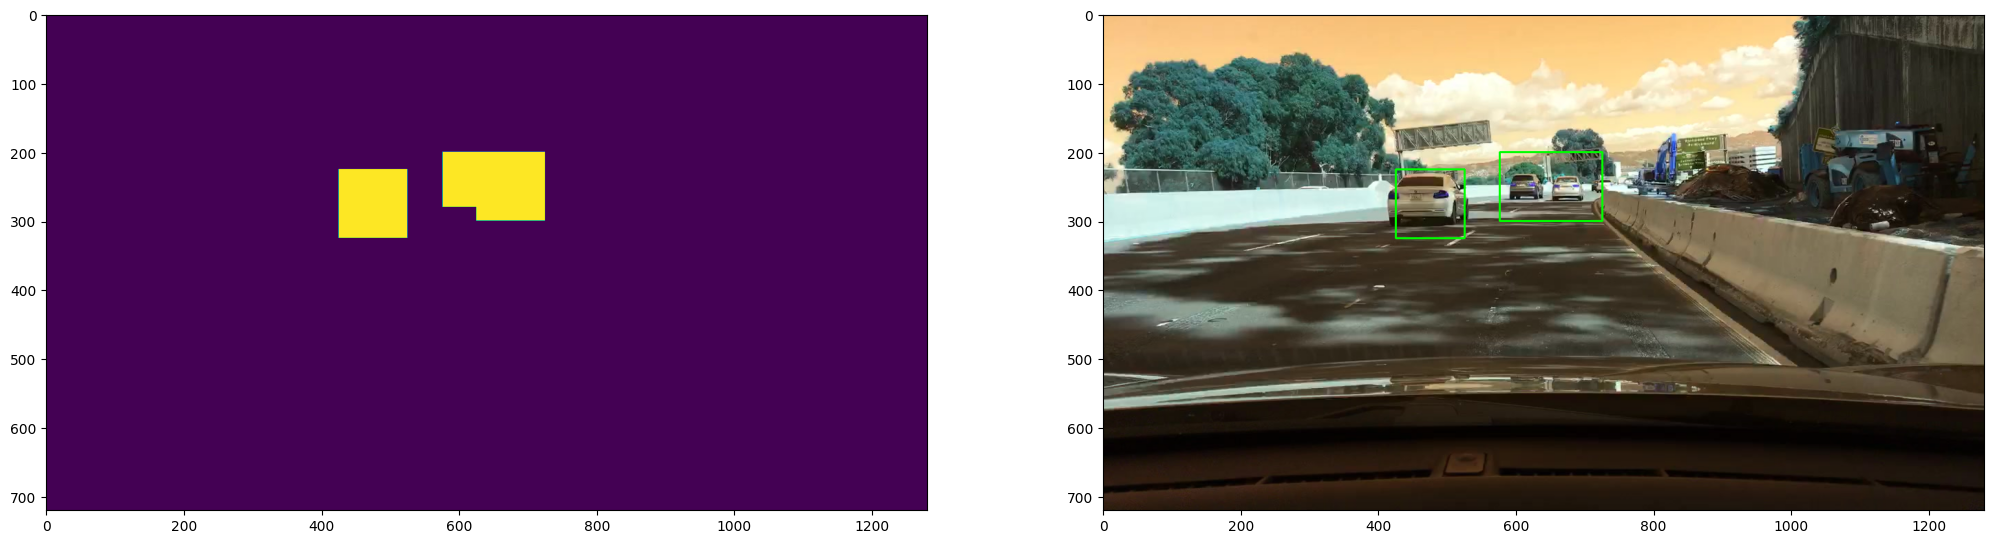

In [12]:
import pandas as pd
from utils import sliding_window
import numpy as np
import pickle
from utils import create_bounding_boxes_df
from skimage.feature import hog
import matplotlib.pyplot as plt

MODEL_PATH = "models/randomforest.model"
model = pickle.load(open(MODEL_PATH, "rb"))
sizes = [64,100,250]

img_path = "test/001.jpg"
image = cv2.imread(img_path)[:,:,::-1]
boxes = []
for size in sizes:
    for window, coords in sliding_window(image, size, stride = size//4):
        # resizing the image
        new_size = (64, 64)
        resized_window = cv2.resize(window, new_size)
        
        # Extracting the features
        fd, hog_image = hog(resized_window, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), visualize=True,channel_axis=-1)

        # Features reshaping
        fd = fd.reshape(-1, 1)
        fd = np.transpose(fd,(1,0))

        # Getting a probability
        proba = model.predict_proba(fd)

        if proba[0][1] > 0.85:
            boxes += [coords[0],coords[1] , coords[2], coords[3]]

img =  image[:,:,::-1]
heatmap = create_map(boxes, img)
merged_bboxes = connect_components(heatmap)

#df_boxes = create_bounding_boxes_df([merged_bboxes], [img_path])
um = cv2.UMat(img)

# Draw bounding boxes on image
for bbox in merged_bboxes:
    cv2.rectangle(um, (bbox[0], bbox[1]), (bbox[0]+ bbox[2], bbox[1]+ bbox[3]), (0, 255, 0), 2)

# Convert um back to numpy array
img = um.get()
fig, ax = plt.subplots(1,2, figsize = (25,50))
ax[0].imshow(heatmap)
ax[1].imshow(img)

### For the whole dataset

In [3]:
import os
test_files = sorted(os.listdir('./test/'))
test_files = [os.path.join("test", x)for x in test_files]
print(test_files)

['test/001.jpg', 'test/002.jpg', 'test/003.jpg', 'test/004.jpg', 'test/005.jpg', 'test/006.jpg', 'test/007.jpg', 'test/008.jpg', 'test/009.jpg', 'test/010.jpg', 'test/011.jpg', 'test/012.jpg', 'test/013.jpg', 'test/014.jpg', 'test/015.jpg', 'test/016.jpg', 'test/017.jpg', 'test/018.jpg', 'test/019.jpg', 'test/020.jpg', 'test/021.jpg', 'test/022.jpg', 'test/023.jpg', 'test/024.jpg', 'test/025.jpg', 'test/026.jpg', 'test/027.jpg', 'test/028.jpg', 'test/029.jpg', 'test/030.jpg', 'test/031.jpg', 'test/032.jpg', 'test/033.jpg', 'test/034.jpg', 'test/035.jpg', 'test/036.jpg', 'test/037.jpg', 'test/038.jpg', 'test/039.jpg', 'test/040.jpg', 'test/041.jpg', 'test/042.jpg', 'test/043.jpg', 'test/044.jpg', 'test/045.jpg', 'test/046.jpg', 'test/047.jpg', 'test/048.jpg', 'test/049.jpg', 'test/050.jpg', 'test/051.jpg', 'test/052.jpg', 'test/053.jpg', 'test/054.jpg', 'test/055.jpg', 'test/056.jpg', 'test/057.jpg', 'test/058.jpg', 'test/059.jpg', 'test/060.jpg', 'test/061.jpg', 'test/062.jpg', 'test/0

In [8]:
import pandas as pd
from utils import sliding_window, make_sliding_windows
import numpy as np
import pickle
from utils import create_bounding_boxes_df
from skimage.feature import hog
import matplotlib.pyplot as plt
from tqdm import tqdm

MODEL_PATH = "models/randomforest.model"
model = pickle.load(open(MODEL_PATH, "rb"))
sizes = [(64,64),(128,128),(256,256)]
step_sizes = [(16, 16), (32, 32), (64, 64)]
y_start_stop= [(0.3, 0.56), (0.2, 0.7), (0.35, .7)]
boxes_list = []
test_files= test_files

for image_path in tqdm(test_files):
    image = read_img(image_path)
    boxes = []
#    for size in sizes:
    for window, coords in make_sliding_windows(image, sizes, step_sizes, y_start_stop):
        # resizing the image
        new_size = (64, 64)
        resized_window = cv2.resize(window, new_size)
        
        # Extracting the features
        fd, hog_image = hog(resized_window, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), visualize=True,channel_axis=-1)

        # Features reshaping
        fd = fd.reshape(-1, 1)
        fd = np.transpose(fd,(1,0))

        # Getting a probability
        proba = model.predict_proba(fd)
        
        if proba[0][1] > 0.7:
            boxes += [coords[0],coords[1] , coords[2], coords[3]]

    
    heatmap = create_map(boxes, image)
    merged_bboxes = connect_components(heatmap)
    boxes_list.append(merged_bboxes)
    # Draw bounding boxes on image
    
    for bbox in merged_bboxes:
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[0]+ bbox[2], bbox[1]+ bbox[3]), (0, 255, 0), 2)
    cv2.imwrite(os.path.join("results",image_path.split(os.sep)[-1]), image)


create_submission_file(boxes_list,test_files)  

###### PLOT THE LAST IMAGE

# Convert um back to numpy array
img = um.get()
fig, ax = plt.subplots(1,2, figsize = (25,50))
ax[0].imshow(heatmap)
ax[1].imshow(img)

/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Image:  test/001.jpg
Image:  test/002.jpg
Image:  test/003.jpg
Image:  test/004.jpg
Image:  test/005.jpg
Image:  test/006.jpg
Image:  test/007.jpg
Image:  test/008.jpg
Image:  test/009.jpg
Image:  test/010.jpg
Image:  test/011.jpg
Image:  test/012.jpg
Image:  test/013.jpg
Image:  test/014.jpg
Image:  test/015.jpg
Image:  test/016.jpg
Image:  test/017.jpg
Image:  test/018.jpg
Image:  test/019.jpg
Image:  test/020.jpg
Image:  test/021.jpg
Image:  test/022.jpg
Image:  test/023.jpg
Image:  test/024.jpg
Image:  test/025.jpg
Image:  test/026.jpg
Image:  test/027.jpg
Image:  test/028.jpg
Image:  test/029.jpg
Image:  test/030.jpg
Image:  test/031.jpg
Image:  test/032.jpg
Image:  test/033.jpg
Image:  test/034.jpg
Image:  test/035.jpg
Image:  test/036.jpg
Image:  test/037.jpg
Image:  test/038.jpg
Image:  test/039.jpg
Image:  test/040.jpg
Image:  test/041.jpg
Image:  test/042.jpg
Image:  test/043.jpg
Image:  test/044.jpg
Image:  test/045.jpg
Image:  test/046.jpg
Image:  test/047.jpg
Image:  test/

NameError: name 'um' is not defined

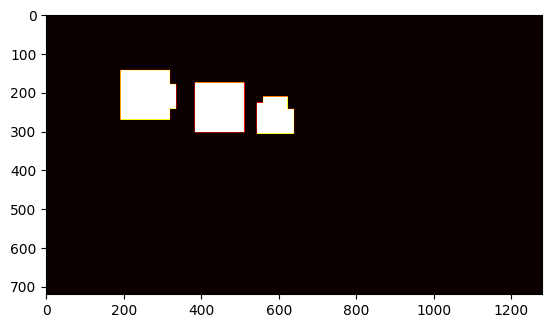

In [19]:
max = heatmap.max()
x,y  = heatmap.shape
for i in range(x):
    for j in range(y):
        heatmap[i,j]= heatmap[i,j]/max

plt.imshow(heatmap, cmap="hot")

In [ ]:
images = boxes_list 

bounding_boxes = []
for img in images:
    bounding_boxes_str = ""
    for boxes in img:
        bounding_boxes_str += " "+' '.join(str(coord) for coord in boxes)
    bounding_boxes.append(bounding_boxes_str)
# Create dataframe with list of strings
pd.DataFrame(data={"frame_id": files[:2], "bounding_boxes": bounding_boxes})
    

,frame_id,bounding_boxes
0,test/001.jpg,520 200 184 104 500 620 64 64
1,test/002.jpg,520 200 184 104 500 620 64 64


In [ ]:
boxes_list = [[[520, 200, 184, 104], [500, 620, 64, 64]],
 [[30, 200, 184, 104], [500, 620, 64, 64]]]